# 残差网络(ResNet - Residual Network)


ResNet是一种深度卷积神经网络，通过引入残差块（Residual Block）来解决深层网络训练中的梯度消失和梯度爆炸问题。它的核心思想是通过残差连接（skip connections）来学习残差，从而能够训练更深的网络结构。

## 背景

在深层神经网络中，梯度在反向传播过程中容易消失或爆炸，导致难以训练非常深的网络。ResNet的提出旨在通过跳过连接，允许网络学习残差，从而解决这些问题。

## 残差块

ResNet的核心是残差块，它是由卷积层、批归一化层和跳过连接组成的。每个残差块可以有不同的深度，但共享相同的思想：将输入与输出相加，以学习残差。

## ResNet的优势

- **训练更深的网络：** 通过残差连接，ResNet允许训练非常深的网络，从而学习更丰富的特征表示。
- **梯度传递更稳定：** 残差连接有助于梯度在网络中更稳定地传递，减少梯度消失和爆炸问题。
- **更好的性能：** ResNet在图像分类、目标检测和分割等任务上取得了出色的性能，成为深度学习中的重要模型之一。


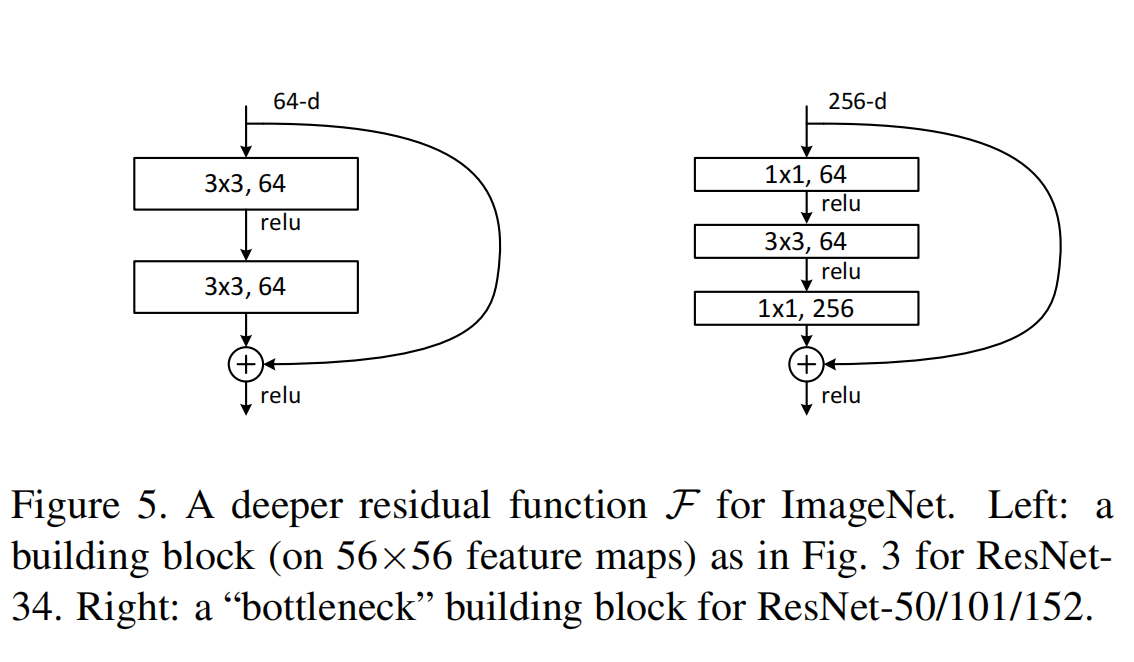

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

import torch
import torch.nn as nn
import torch.nn.functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        """
        定义一个残差块(Residual Block)类,实现残差连接的卷积神经网络结构。

        参数：
        input_channels: 输入通道数
        num_channels: 输出通道数(同时也是每个卷积层的输出通道数)
        use_1x1conv: 是否使用1x1卷积进行维度匹配(默认为False)
        strides: 第一个卷积层的步幅(默认为1)

        属性：
        conv1: 第一个卷积层,3x3卷积,步幅为strides,padding为1,输入通道数为input_channels,输出通道数为num_channels
        conv2: 第二个卷积层,3x3卷积,步幅为1,padding为1,输入通道数和输出通道数都为num_channels
        conv3: 如果use_1x1conv为True,添加一个1x1卷积层,用于维度匹配;否则为None
        bn1: 批量归一化层,对第一个卷积层的输出进行批量归一化
        bn2: 批量归一化层,对第二个卷积层的输出进行批量归一化

        方法：
        forward(X): 前向传播函数,对输入X执行残差块的前向传播操作
        """
        super().__init__()
        # 第一个卷积层,3x3卷积,步幅为strides,padding为1,输入通道数为input_channels,输出通道数为num_channels
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        # 第二个卷积层,3x3卷积,步幅为1,padding为1,输入通道数和输出通道数都为num_channels
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        # 如果使用1x1卷积进行维度匹配(当输入通道数与输出通道数不一致时),添加一个1x1卷积层
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        # 批量归一化层,对第一个卷积层的输出进行批量归一化
        self.bn1 = nn.BatchNorm2d(num_channels)
        # 批量归一化层,对第二个卷积层的输出进行批量归一化
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        """
        前向传播函数,对输入X执行残差块的前向传播操作。

        参数：
        X: 输入数据

        返回：
        Y: 残差块的输出
        """
        # 第一个卷积层的前向传播：卷积 -> 批量归一化 -> ReLU激活函数
        Y = F.relu(self.bn1(self.conv1(X)))
        # 第二个卷积层的前向传播：卷积 -> 批量归一化
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            # 如果使用了1x1卷积进行维度匹配,将输入通过1x1卷积层进行变换以匹配维度
            X = self.conv3(X)
        # 将第二个卷积层的输出与可能经过1x1卷积的输入相加,实现残差连接
        Y += X
        # 应用ReLU激活函数
        return F.relu(Y)

In [2]:
# 高宽不变
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [3]:
# 高宽减半,通道数加倍,使用1x1卷积核实现X的高宽减半,通道数加倍,便于Y += X
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())